In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rs = pd.read_csv('Regular_Season.csv')
po = pd.read_csv('Playoff.csv')
mvp = pd.read_csv('mvp.csv')

custom_palette = {
    'Playoff': '#fc8d62',
    'Regular Season': '#8da0cb',
}

custom_palette2 = {
    'PF': '#66c2a5',
    'PG': '#fc8d62',
    'C': '#8da0cb',
    'SF': '#e78ac3',
    'SG': '#a6d854',
}

top_players = mvp['Player'].tolist()

<div>
    <img src="logo.png" width="700px">
    <p><i>Candidati all'mvp</i> VS <i>Resto della lega</i>, come varia il rendimento dei giocatori tra Regular Season e Playoff</p>
</div>

<b style="font-size:65px">Il Dataset</b>

Reso disponibile dalla compagnia <i>Sports Reference</i> 

https://www.basketball-reference.com/

In [2]:
rs.head(7)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,EFF
0,1,Shai Gilgeous-Alexander,26,OKC,PG,76,76,34.2,11.3,21.8,...,4.1,5.0,6.4,1.7,1.0,2.4,2.2,32.7,MVP-1DPOY-10CPOY-8ASNBA1,30.8
1,2,Giannis Antetokounmpo,30,MIL,PF,67,67,34.2,11.8,19.7,...,9.7,11.9,6.5,0.9,1.2,3.1,2.3,30.4,MVP-3DPOY-8ASNBA1,33.5
2,3,Nikola Jokić,29,DEN,C,70,70,36.7,11.2,19.5,...,9.9,12.7,10.2,1.8,0.6,3.3,2.3,29.6,MVP-2CPOY-2ASNBA1,39.8
3,4,Luka Dončić,25,2TM,PG,50,50,35.4,9.2,20.5,...,7.4,8.2,7.7,1.8,0.4,3.6,2.5,28.2,NaN,27.2
4,4,Luka Dončić,25,DAL,PG,22,22,35.7,9.8,21.2,...,7.6,8.3,7.8,2.0,0.4,3.4,2.6,28.1,NaN,27.7
5,4,Luka Dončić,25,LAL,PG,28,28,35.1,8.8,20.0,...,7.2,8.1,7.5,1.6,0.4,3.7,2.4,28.2,NaN,26.6
6,5,Anthony Edwards,23,MIN,SG,79,79,36.3,9.1,20.4,...,4.9,5.7,4.5,1.2,0.6,3.2,1.9,27.6,MVP-7CPOY-3ASNBA2,22.2


In [3]:
print('EFF = PTS + TRB + AST + STL + BLK - [TOV + PF + (FGA - FG) + (FTA - FT)]')

EFF = PTS + TRB + AST + STL + BLK - [TOV + PF + (FGA - FG) + (FTA - FT)]


<b>Domanda 1:</b> Come varia il rendimento dei giocatori tra Regular Season e Playoff?

In [4]:
# creiamo il DataFrame con i giocatori che hanno partecipato sia a rs che po
both_completo = pd.merge(rs, po, how='right', on='Player', suffixes=('_RS', '_PO'))

# per la prima parte consideriamo solo i giocatori 'normali', escludendo i candidati mvp
both_completo_senza_top = both_completo[~both_completo['Player'].isin(top_players)]

# teniamo solo le colonne che ci servono per il grafico
both = both_completo_senza_top[['Player', 'EFF_RS', 'EFF_PO']]

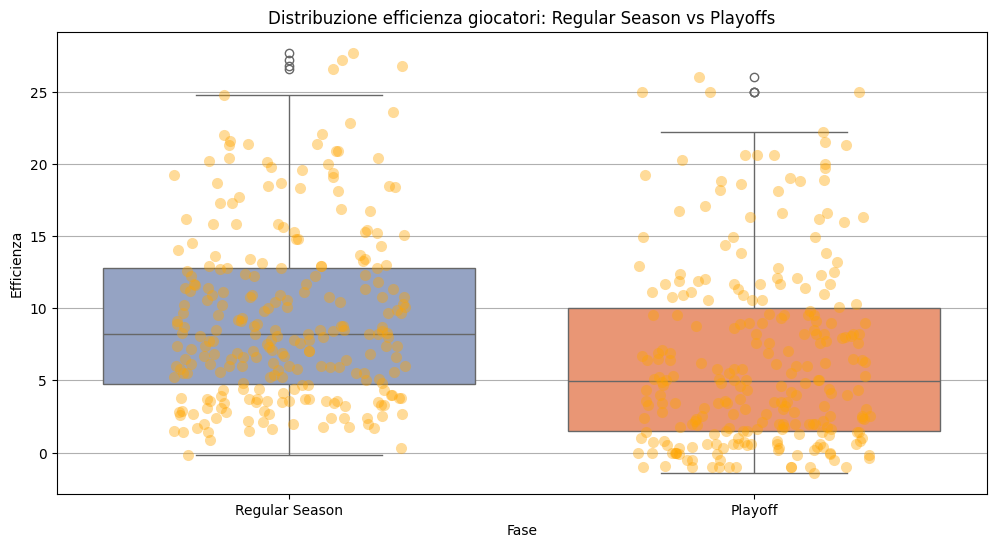

In [5]:
# MultiIndex
both_multi = both.set_index("Player")
both_multi.columns = pd.MultiIndex.from_tuples([("EFF", "RS"), ("EFF", "PO")])

both_long = both_multi["EFF"].stack().reset_index()

both_long.columns = ["Player", "Fase", "EFF"]

# rinomino i valori EFF_RS e EFF_PO per renderli più comprensibili e per poter usare la palette
both_long['Fase'] = both_long['Fase'].map({'RS': 'Regular Season', 'PO': 'Playoff'})

# grafico
plt.figure(figsize=(12,6))
sns.boxplot(data=both_long, x='Fase', y='EFF', palette=custom_palette, hue="Fase")
plt.title('Distribuzione efficienza giocatori: Regular Season vs Playoffs')
plt.xlabel('Fase')
plt.ylabel('Efficienza')
plt.grid(True, axis='y')
sns.stripplot(x="Fase", y="EFF", data=both_long, jitter=.25, color='orange', alpha=0.4, size=8)

plt.show()

<b>Domanda 2:</b> Quali sono le statistiche che calano maggiormente?

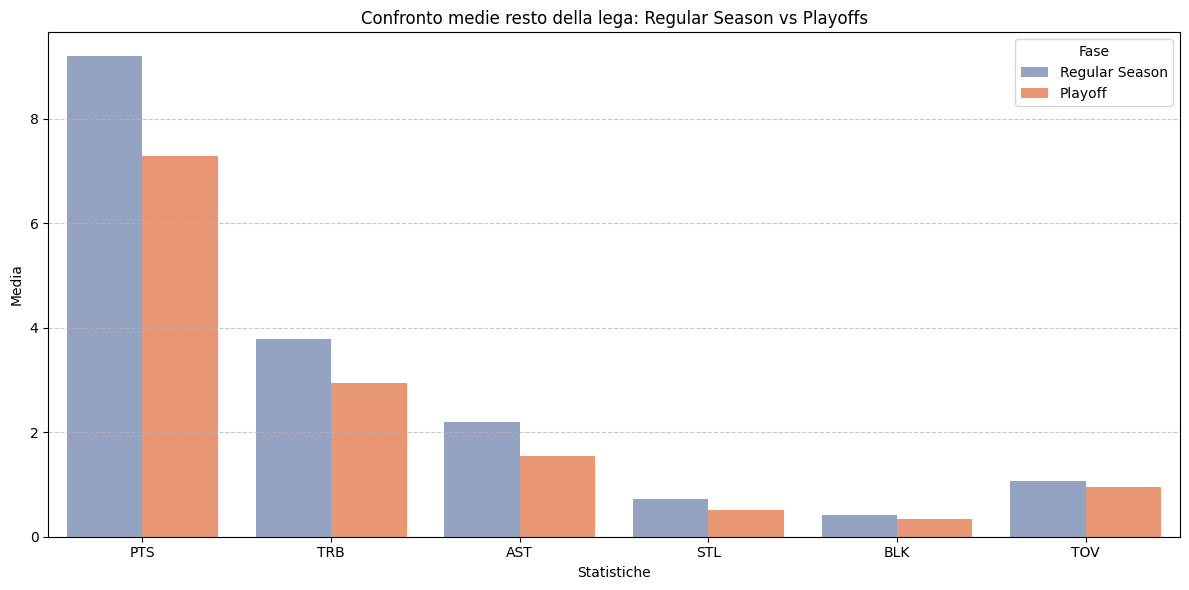

In [6]:
stats = ['PTS_RS', 'TRB_RS', 'AST_RS', 'STL_RS', 'BLK_RS', 'TOV_RS',
        'PTS_PO', 'TRB_PO', 'AST_PO', 'STL_PO', 'BLK_PO', 'TOV_PO']

# assegnamo 0 alle statistiche mancanti
both_completo_senza_top.loc[:, stats] = both_completo_senza_top.loc[:, stats].fillna(0)

medie = both_completo_senza_top[stats].mean()

# Trasforma la Series 'medie' in DataFrame
medie = medie.reset_index()
medie.columns = ['Stats_Fase', 'Media']

# Divido la colonna 'Statistic_Fase' in 'Statistic' e 'Fase'
medie['Fase'] = medie['Stats_Fase'].apply(lambda x: 'Regular Season' if x.endswith('_RS') else 'Playoff')
medie['Stats'] = medie['Stats_Fase'].str.replace('_RS', '').str.replace('_PO', '')

# grafico
plt.figure(figsize=(12,6))
sns.barplot(data=medie, x='Stats', y='Media', hue='Fase', palette=custom_palette)
plt.title('Confronto medie resto della lega: Regular Season vs Playoffs')
plt.xlabel('Statistiche')
plt.ylabel('Media')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

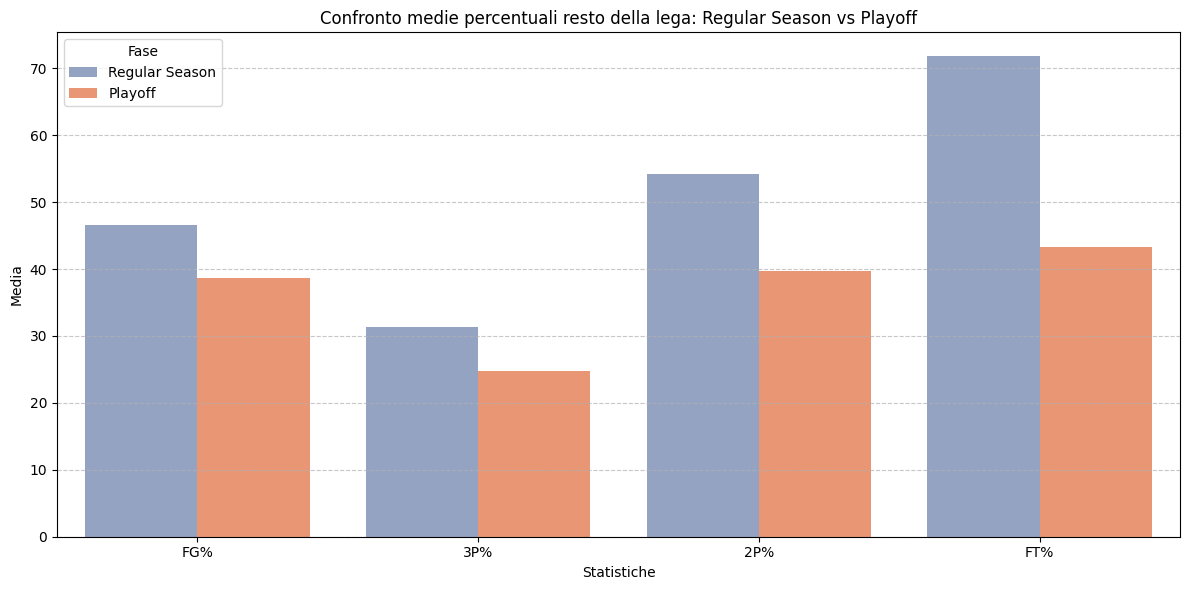

In [7]:
statsP = ['FG%_RS', '3P%_RS', '2P%_RS', 'FT%_RS',
          'FG%_PO', '3P%_PO', '2P%_PO', 'FT%_PO',]

both_completo_senza_top.loc[:, statsP] = both_completo_senza_top.loc[:, statsP].fillna(0)

medieP = both_completo_senza_top[statsP].mean()

# Trasforma la Series 'medieP' in DataFrame
medieP = medieP.reset_index()
medieP.columns = ['Stats_Fase', 'Media']

# Divido la colonna 'Statistic_Fase' in 'Stats' e 'Fase' 
medieP['Fase'] = medieP['Stats_Fase'].apply(lambda x: 'Regular Season' if x.endswith('_RS') else 'Playoff')
medieP['Stats'] = medieP['Stats_Fase'].str.replace('_RS', '').str.replace('_PO', '')

# grafico
plt.figure(figsize=(12,6))
sns.barplot(data=medieP, x='Stats', y='Media', hue='Fase', palette=custom_palette)
plt.title('Confronto medie percentuali resto della lega: Regular Season vs Playoff')
plt.xlabel('Statistiche')
plt.ylabel('Media')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<b>Domanda 3:</b> Quali sono i ruoli che risentono maggiormente l'entrata ai playoff?

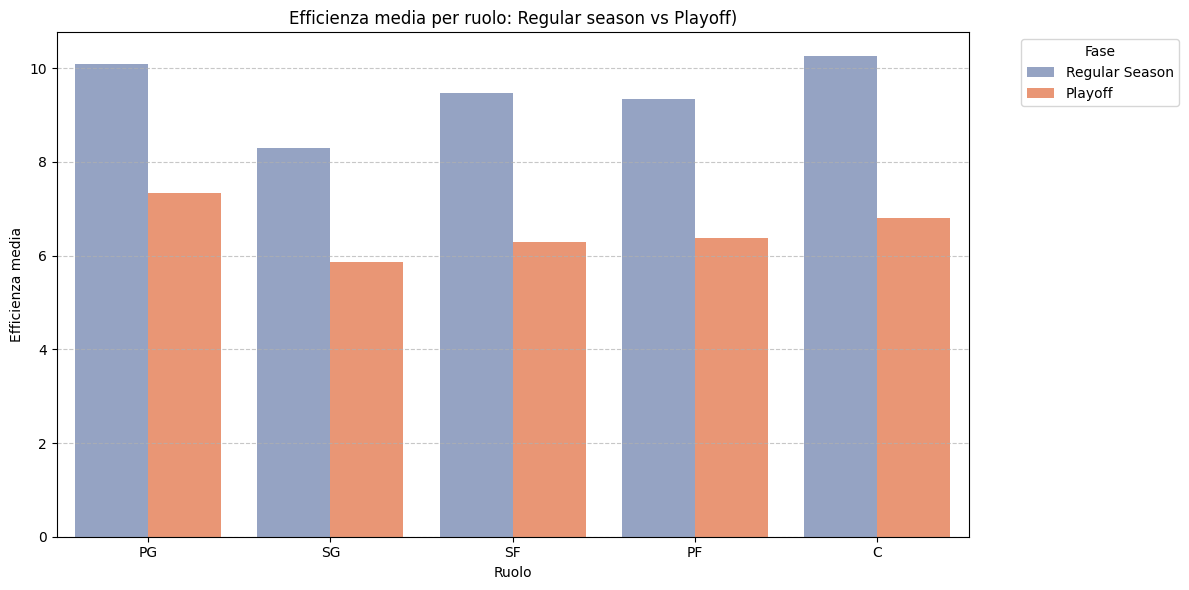

In [8]:
both2 = both_completo_senza_top[['Pos_RS', 'EFF_RS', 'EFF_PO']]

both2 = both2.groupby('Pos_RS').mean()

# MultiIndex
both2.columns = pd.MultiIndex.from_tuples([('EFF', 'RS'), ('EFF', 'PO')])

both_long = both2['EFF'].stack().reset_index()
both_long.columns = ['Pos_RS', 'Fase', 'EFF']

# rinomino i valori EFF_RS e EFF_PO per renderli più comprensibili
both_long['Fase'] = both_long['Fase'].map({'RS': 'Regular Season', 'PO': 'Playoff'})

order = ['PG', 'SG', 'SF', 'PF', 'C']

# grafico
plt.figure(figsize=(12,6))
sns.barplot(data=both_long, x='Pos_RS', y='EFF', hue='Fase', palette=custom_palette, order=order)
plt.title('Efficienza media per ruolo: Regular season vs Playoff)')
plt.ylabel('Efficienza media')
plt.xlabel('Ruolo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Fase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
result = both_long.pivot(index='Pos_RS', columns='Fase', values='EFF')

result['Diff'] = result['Regular Season'] - result['Playoff']

result.sort_values(by='Diff', ascending=False, inplace=True)

print('Differenza efficienza per ruolo:')

for pos, row in result.iterrows():
    print(f"{pos}: {row['Diff']:.3f}")

Differenza efficienza per ruolo:
C: 3.445
SF: 3.182
PF: 2.978
PG: 2.750
SG: 2.441


<b>Domanda 4:</b> L'età influisce sul rendimento dei giocatori?

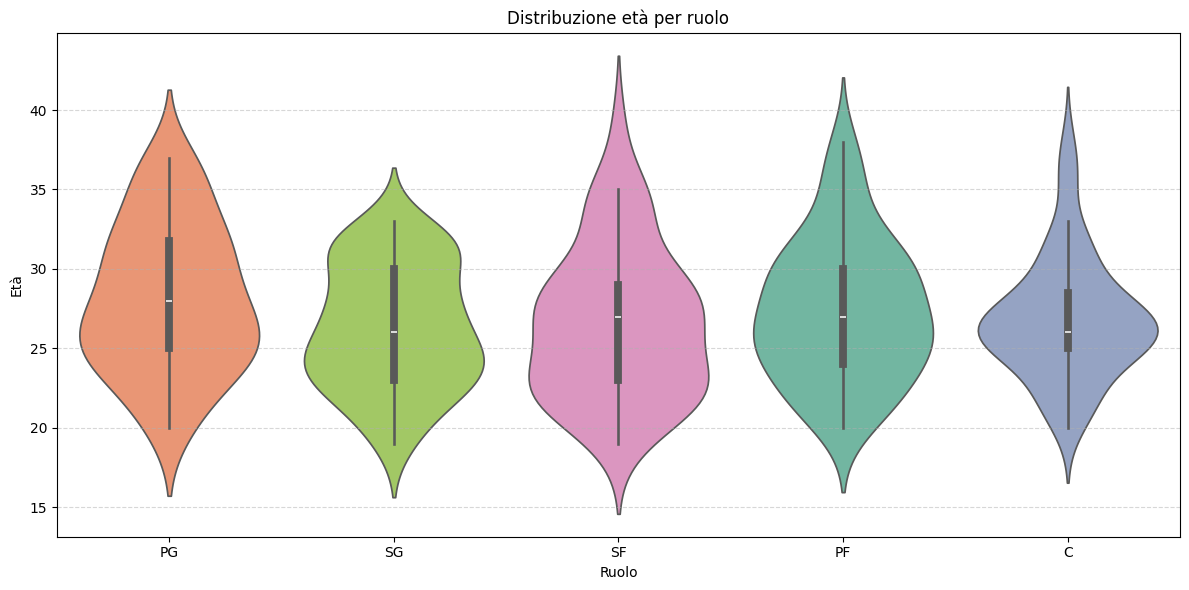

In [10]:
# grafico
plt.figure(figsize=(12,6))
sns.violinplot(data=both_completo_senza_top, x='Pos_RS', y='Age_RS', hue='Pos_RS', palette=custom_palette2, order=order)
plt.title('Distribuzione età per ruolo')
plt.xlabel('Ruolo')
plt.ylabel('Età')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [11]:
età = both_completo_senza_top.groupby('Pos_RS')['Age_RS'].mean()
età = età.reset_index()
età.sort_values(by='Age_RS', ascending=False, inplace=True)

print('Età media per ruolo:')

for _, row in età.iterrows():
    print(f"{row['Pos_RS']}: {row['Age_RS']:.2f}")

Età media per ruolo:
PG: 28.09
PF: 27.39
C: 26.84
SF: 26.58
SG: 26.29


<b>Domanda 5:</b> I migliori giocatori della lega seguono questi trend o si discostano da essi?

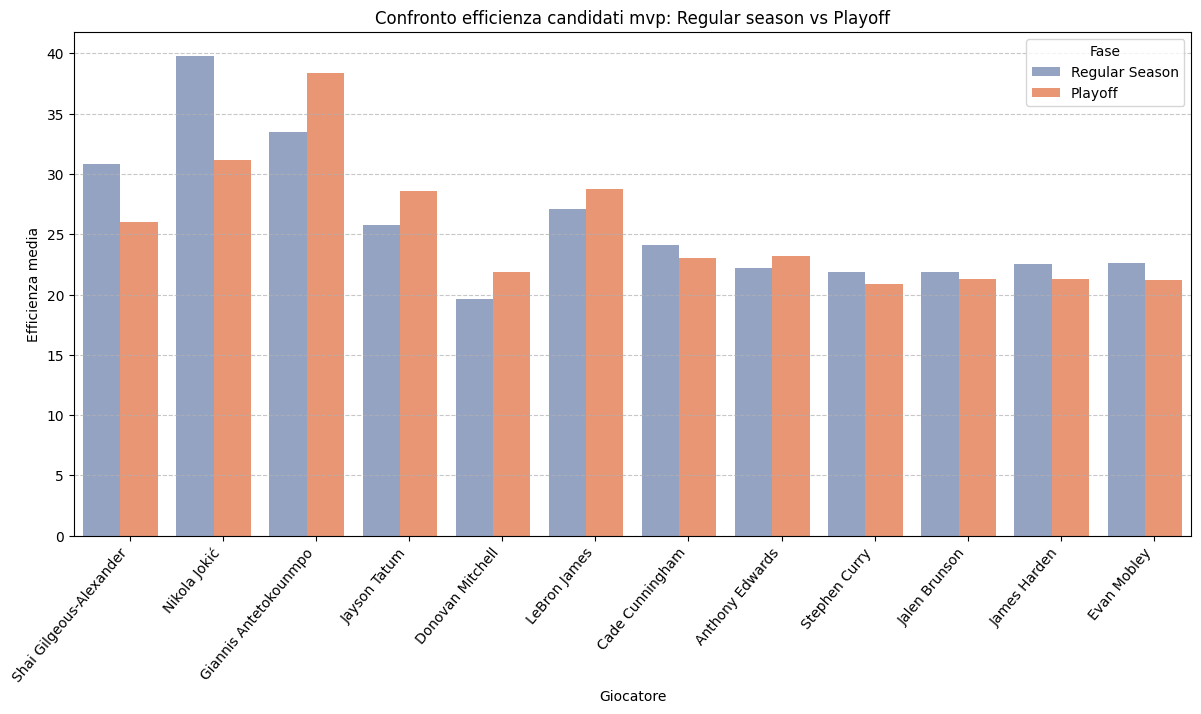

In [12]:
mvp_both = pd.merge(mvp, both_completo, how='left', on='Player', suffixes=('_RS', '_PO'))

mvp_eff = mvp_both[["Player", "EFF_RS", "EFF_PO"]]

# MultiIndex 
mvp_eff_multi = mvp_eff.set_index("Player")
mvp_eff_multi.columns = pd.MultiIndex.from_tuples([("EFF", "RS"), ("EFF", "PO")])

mvp_eff_long = mvp_eff_multi["EFF"].stack().reset_index()

mvp_eff_long.columns = ["Player", "Fase", "EFF"]

mvp_eff_long['Fase'] = mvp_eff_long['Fase'].map({'RS': 'Regular Season', 'PO': 'Playoff'})

# grafico
plt.figure(figsize=(12,6))
sns.barplot(data=mvp_eff_long, x='Player', y='EFF', hue='Fase', palette=custom_palette)
plt.title('Confronto efficienza candidati mvp: Regular season vs Playoff')
plt.ylabel('Efficienza media')
plt.xlabel('Giocatore')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

posizioni, etichette = plt.xticks()
posizioni = np.array(posizioni) 
plt.xticks(posizioni + 0.1, etichette, rotation=50, ha='right')

plt.show()

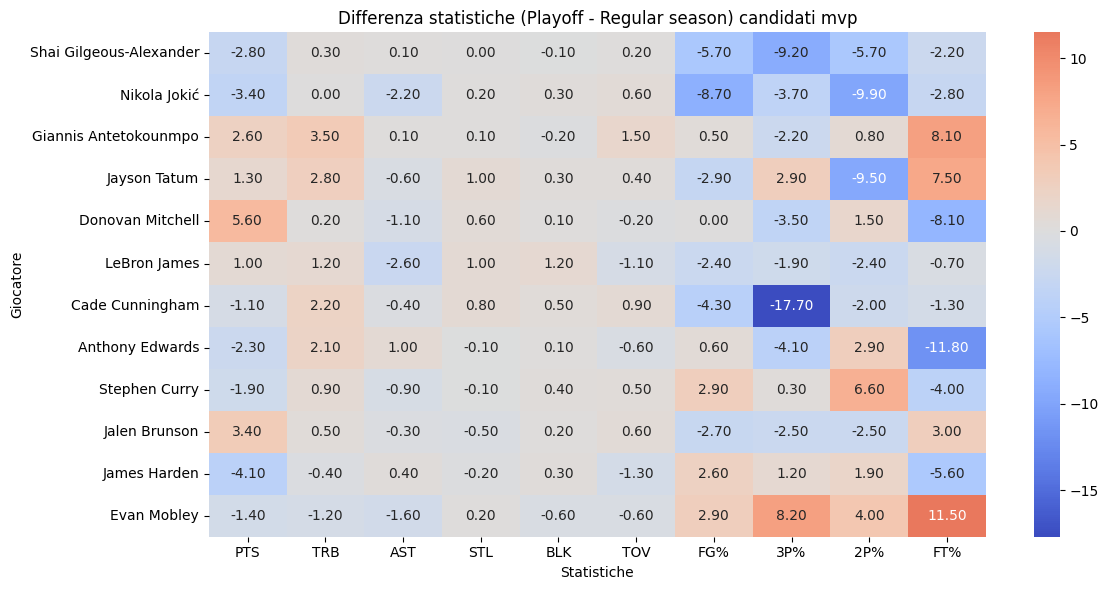

In [13]:
all_stats = ['PTS_RS', 'TRB_RS', 'AST_RS', 'STL_RS', 'BLK_RS', 'TOV_RS', 'FG%_RS', '3P%_RS', '2P%_RS', 'FT%_RS',
        'PTS_PO', 'TRB_PO', 'AST_PO', 'STL_PO', 'BLK_PO', 'TOV_PO', 'FG%_PO', '3P%_PO', '2P%_PO', 'FT%_PO']

# Creiamo un DataFrame nuovo con solo le colonne Player e quelle di all_stats
df_stats = mvp_both[['Player'] + all_stats].copy()

# Lista di statistiche base (senza _RS e _PO)
stats_base = [col[:-3] for col in all_stats if col.endswith('_RS')]

# Calcoliamo le differenze PO - RS per ciascuna statistica
for stat in stats_base:
    df_stats[stat] = df_stats[stat + '_PO'] - df_stats[stat + '_RS']

# Manteniamo solo Player e colonne di differenza
diff_cols = ['Player'] + stats_base
df_diff = df_stats[diff_cols]

# Impostiamo Player come indice per la heatmap
df_heatmap = df_diff.set_index('Player')

# grafico
plt.figure(figsize=(12,6))
sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.ylabel('Giocatore')
plt.xlabel('Statistiche')
plt.title("Differenza statistiche (Playoff - Regular season) candidati mvp")
plt.tight_layout()
plt.show()

# valori negativi = calo
# valori positivi = miglioramento

<b style="font-size:65px">Conclusioni</b>

<li>In generale il rendimento di tutti i giocatori della lega cala una volta entrati ai playoff</li>

<li>Ad essere maggiormente penalizzate non sono più di tanto le statistiche quanto più le percentuali</li>

<li>I ruoli più fisici sono quelli che risentono maggiormente il cambio di ritmo dei playoff</li>

<li>L'età non ha un peso significativo, ma qualche leggera relazione c'è: ruoli più giovani soffrono più di quelli più anziani</li>

<li>I top player riescono a mantenere più stabile il proprio rendimento rispetto al resto della lega</li>

<li>Anche per i top player a calare maggiormente sono le percentuali piuttosto che le statistiche</li>